In [ ]:
# Comparing Models (GAM and GLM) Using Squid CPUE Standardization and Forecasting 

# Lu et al. (2013) applied a Generalized Linear Bayesian Model (GLBM) to standardize CPUE for Illex argentinus, incorporating various environmental and spatial variables within a Bayesian framework. However, due to the increased computational complexity and the need for specialized probabilistic programming tools, this portfolio instead adopts a simplified, interpretable alternative: a linear GAM using ln(CPUE + c), inspired by the structure of Lu et al.'s model. This provides a practical balance between model flexibility and accessibility for exploratory analysis. ”
# Lu et al's Generalized Linear Bayesian Model (GLBM) for standardized CPUE formula =ln(CPUE+c)=factor(year)+factor(month)+s(longitude)+s(latitude)+s(SST)+s(SSH)+s(Chl a)+ϵ. 
# in stock size of I. argentinus. The CPUE was assumed to be normally distributed and log-transformed with errors in the GLBM modelling."
# - c = constant that was assumed to be 10% of the mean yearly CPUE
# - Expected_Ln_CPUE=Intercept+∑(Coefficients X Predictors)
# - Standardized CPUE = exp(Expected_Ln_CPUE)-c/exp(Expected_Ln_CPUE)-1 (for linear GAM) and just the predictions for GammaGAM and Tweedie GLM


# --------------------------------------------------
# This notebook trains and evaluates three variants of the GAM:
# - GAM (Additive Model)
# - Linear GAM (Generalized Additive Model _ log_CPUE_plus_1)
# - Gamma GAM (Generalized Additive Model _ log_CPUE_plus_1)
# and one GLM:
# - Tweedie GLM (Generalized Linear Model with df=4 and var_power=2[Gamma_distribution])
# using monthly CPUE, with full diagnostics.

In [19]:
# Loading Modules
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import os
from patsy import bs
import plotly.graph_objects as go
import plotly.express as px
from pygam import LinearGAM, s, f
from pygam import GammaGAM, s, f
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [3]:
# Load and prepare data
df = pd.read_csv("../data/Final_dataset.csv")
required_cols = ["SqCatch_Kg", "Depth", "Lat", "Lon", "WaterTemp", "Chlor_a_mg_m3", "Month", "Year", "Day", "SSH"]
df.dropna(subset=required_cols, inplace=True)

# Filter for Jan–June
df = df[df["Month"].between(1, 6)]

# Create CPUE per day
df["CPUE"] = df["SqCatch_Kg"] 
df.head()


,POINTID,CTNO,Year,Month,Day,Lon,Lat,WaterTemp,SSH,Depth,Chlor_a_mg_m3,SqCatch_Kg,CPUE
0,1,10001,2000,1,1,-60.758637,-46.297230,14.0,0.0201,80.0,0.903811,13922.858090,13922.858090
1,2,10001,2000,1,2,-60.589546,-46.319036,13.9,0.0201,85.0,0.903811,4284.774801,4284.774801
2,3,10001,2000,1,3,-60.653497,-46.096548,14.7,0.0201,85.0,0.903811,8263.649496,8263.649496
3,4,10001,2000,1,4,-60.697349,-45.962174,15.6,0.0201,85.0,0.903811,12870.823170,12870.823170
4,5,10001,2000,1,5,-60.691715,-46.148531,14.2,0.0201,90.0,0.903811,5637.852315,5637.852315


In [21]:

model_summary_data = [
    {
        "Model_Name": "LinearGAM_log_CPUE_plus_c",
        "Distribution": "Normal",
        "Link_Function": "Identity",
        "Target": "log(CPUE + c)",
        "Notes": "Log transform with constant c to avoid log(0)"
    },
    {
        "Model_Name": "LinearGAM_log_CPUE_plus_1",
        "Distribution": "Normal",
        "Link_Function": "Identity",
        "Target": "log(CPUE + 1)",
        "Notes": "Log transform with +1"
    },
    {
        "Model_Name": "GammaGAM_CPUE",
        "Distribution": "Gamma",
        "Link_Function": "Log",
        "Target": "CPUE",
        "Notes": "Used Gamma distribution for skewed CPUE"
    },
    {
        "Model_Name": "TweedieGLM_CPUE",
        "Distribution": "Tweedie",
        "Link_Function": "Log",
        "Target": "CPUE",
        "Notes": "Tweedie GLM for zero-inflated CPUE"
    }
]

model_summary = pd.DataFrame(model_summary_data)
model_summary.to_csv("../results/summaries/model_summary.csv", index=False)


In [4]:
# Compute Monthly CPUE
monthly_cpue = (
    df.groupby(["Year", "Month"])
    .agg(
        TotalCatch=("CPUE", "sum"),
        DaysFished=("Day", "count")
    )
    .reset_index()
)
monthly_cpue["Monthly_CPUE"] = monthly_cpue["TotalCatch"] / monthly_cpue["DaysFished"]
monthly_cpue.sort_values(["Year", "Month"], inplace=True)

monthly_cpue.to_csv("../results/summaries/monthly_cpue.csv", index=False)

# Compute weighted average Latitude and Longitude per Year and Month
def weighted_mean(group, value_col, weight_col):
    return (group[value_col] * group[weight_col]).sum() / group[weight_col].sum()

weighted_coords = (
    df.groupby(["Year", "Month"])
    .apply(lambda g: pd.Series({
        "Weighted_Latitude": weighted_mean(g, "Lat", "CPUE"),
        "Weighted_Longitude": weighted_mean(g, "Lon", "CPUE")
    }))
    .reset_index()
)

# Merge back with features
ftba = ["WaterTemp", "Depth"] # "ftba" stands for features to be avergaed
aaf = ["SSH", "Chlor_a_mg_m3"] # "aaf" stands for already avergaed features

#Creating dataframes to merge after grouping them by months.
averaged_features = df.groupby(["Year", "Month"])[ftba].mean().reset_index()
already_averaged = df.groupby(["Year", "Month"])[aaf].first().reset_index()
data = monthly_cpue.merge(averaged_features, on=["Year", "Month"]).merge(weighted_coords, on=["Year", "Month"]).merge(already_averaged, on=["Year", "Month"])
data.head()

,Year,Month,TotalCatch,DaysFished,Monthly_CPUE,WaterTemp,Depth,Weighted_Latitude,Weighted_Longitude,SSH,Chlor_a_mg_m3
0,2000,1,2.588951e+07,2177,11892.288772,13.772538,76.641709,-46.533534,-60.723543,0.0201,0.903811
1,2000,2,6.305128e+07,2737,23036.638502,13.234984,78.006577,-47.162833,-61.276076,0.0178,1.546665
2,2000,3,7.175835e+07,2944,24374.440194,12.151003,84.641644,-47.567805,-60.756138,0.0150,0.690164
3,2000,4,3.532778e+07,2822,12518.701380,10.106035,96.687810,-48.823479,-61.871991,0.0097,0.591688
4,2000,5,2.437390e+07,2739,8898.831789,8.781864,107.336254,-47.660462,-61.109375,0.0109,0.442545


In [5]:
# Log-transform CPUE for Linear GAM (with c = 10% of mean yearly CPUE)
yearly_mean_cpue = (
    data.groupby("Year")["Monthly_CPUE"].mean()
)
yearly_mean_cpue.name = "Yearly_Mean_CPUE"

# Merge back to full data
data_df =  data.merge(yearly_mean_cpue, on="Year")

# finding 10% of Yearly_Mean_CPUE(constant/c) in data to avoid zero when log-transforming CPUE
data_df["c"] =  0.1 * data_df["Yearly_Mean_CPUE"]

#log Transforming the monthly CPUE + c then adding it to a new column in the full df
data_df["Log_CPUE_plus_c"] = np.log(data_df["Monthly_CPUE"] + data_df["c"])


#log Transforming the monthly CPUE + 1 then adding it to a new column in the full df
data_df["Log_CPUE_plus_1"] = np.log(data_df["Monthly_CPUE"] + 1)


# Features and Target
glbm_features = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]

# setting the "Year" column as integer
data_df["Year"] = data_df["Year"].astype(int)


#Making a copy of the full dataset for standardization
full_df = data_df



#Double checking if there are values that are zero or below in the full dataframe to know which methid aside from linear GAM takes priority for predictions
num_values_zero_and_below = (full_df["Monthly_CPUE"] <= 0).sum()
total_values = len(full_df["Monthly_CPUE"])

if num_values_zero_and_below == 0:
    print(f"Since there are:{num_values_zero_and_below} values out of {total_values} then it would be best to proceed with GammaGam and maybe consider TweedieGAM for outliers")
else:
    print(f"Since there are:{num_values_zero_and_below} values out of {total_values} then it would be best to proceed with TweedieGam")

# Split: 2000-2014 (train), 2015-2020 (test)
train_df = full_df[full_df["Year"] < 2014].copy()
test_df = full_df[full_df["Year"] >= 2015].copy()
#y_test = test_df["Monthly_CPUE"]  # for evaluation

Since there are:0 values out of 110 then it would be best to proceed with GammaGam and maybe consider TweedieGAM for outliers


In [6]:
# Standardization Using LinearGAM (GLBM)(log(CPUE + c))
# Features and Target
features = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]

#Making a copy of the full dataset for standardization
full_df = data_df

#Subsetting full_df for only the features we would need to train the data
X_all = full_df[features]

# Target for LinearGAM 
y_all = full_df["Log_CPUE_plus_c"]

# Fit GLBM (GAM-like structure)
linear_gam_c_std = LinearGAM(f(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))

# Fit the model on full data
linear_gam_c_std.fit(X_all, y_all)

# Predict standardized log(CPUE + c) for every row
linear_gam_c_all = linear_gam_c_std.predict(X_all)

# Back-transform to standardized CPUE
standardized_log_cpueC = np.exp(linear_gam_c_all) - full_df["c"]

# Store result
full_df["Standardized_log_cpueC"] = standardized_log_cpueC


In [7]:
# Standardization Using Linear_GAM (log(CPUE + 1))
# Select features used in the model 
features = ["Year", "Month", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Depth"]
X_all = full_df[features]

# Target for LinearGAM 
y_all = full_df["Log_CPUE_plus_1"]

# Fit the GAM model on full data
linear_gam_1_std = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)).fit(X_all, y_all)

# Predict on all data (standardized log(CPUE + 1))
linear_gam_1_all = linear_gam_1_std.predict(X_all)

# Back-transform to CPUE
standardized_log_cpue1 = np.exp(linear_gam_1_all) - 1

# Store result
full_df["Standardized_log_cpue1"] = standardized_log_cpue1



In [8]:
# Standardization Using GammaGAM
# Features and Target
features = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]


# Features
X_all = full_df[features]

# Target for GammaGAM (no log-transform needed)
y_all = full_df["Monthly_CPUE"]

# Fit GammaGAM
# Because CPUE can vary sharply between months (e.g., seasonal fishing behavior, spawning), we will use a factor for flexibility.
# Since years often follow a longer trend (e.g., stock depletion, climate change) we will use a spline to prevent overfitting the yearly spikes and ensure better generalization to other years. This was seen in the trend from the time series EDA we could have seen that the yearly spikes are real but rare .
gamma_gam_std = GammaGAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))
gamma_gam_std.fit(X_all, y_all)

# Predict CPUE 
gamma_gam_std_all = gamma_gam_std.predict(X_all)

# Subtract the constant to get back standardized CPUE
standardized_cpue_GammaGAM = gamma_gam_std_all 

# Store result
full_df["Standardized_CPUE_GammaGAM"] = standardized_cpue_GammaGAM


In [9]:
# Standardization Using tweedieglm
# Create the formula with splines
formula = """
Monthly_CPUE ~ C(Month) + bs(Year, df=6) + bs(Weighted_Latitude, df=6) +
 bs(Weighted_Longitude, df=6) + bs(WaterTemp, df=6) + 
bs(Chlor_a_mg_m3, df=6) + bs(SSH, df=6) + bs(Depth, df=6)
"""

# Fit the model
tweedie_glm = smf.glm(formula=formula, data=full_df,
family=sm.families.Tweedie(var_power=1.5, link=sm.families.links.log())).fit()

# Predict
full_df["Standardized_CPUE_tweedieglm"] = tweedie_glm.predict(full_df)



In [10]:
# Prediction Using LinearGAM (GLBM)(log(CPUE + c))
# Features and Target
features = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]
X_train = train_df[features]
X_test = test_df[features]

#log transforming data for training
y_train = np.log(train_df["Monthly_CPUE"] + train_df["c"])
y_test_linear = test_df["Monthly_CPUE"]  # for evaluation

# Fit GLBM (GAM-like structure)
linear_gam_c_prd = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))

# Train the model on part of the data
linear_gam_c_prd.fit(X_train, y_train)

# Predict log(CPUE + c) on test set
linear_gam_c_preds = linear_gam_c_prd.predict(X_test)

#Saving constant column for evaluation
lin_gam_c = test_df["c"]

# Back-transform to predicted CPUE (standardized)
linear_gam_c_preds_all = np.exp(linear_gam_c_preds) - lin_gam_c

#checking the amount of negatives values for glbm_preds
num_negatives = (linear_gam_c_preds_all < 0).sum()
total_preds = len(linear_gam_c_preds_all)
percent_negative = (num_negatives / total_preds) * 100

print(f"Negative predictions: {num_negatives} out of {total_preds} ({percent_negative:.2f}%)")

# 6 out of 29 predictions (20.69%) being negative means that about 1 in 5 predictions is unusable — which can bias results and understate CPUE trends hence why we clip to 0.
# The current LinearGAM with log-transformed CPUE (log(CPUE + c)) is not modeling the data well enough to avoid invalid predictions.

linear_gam_c_preds_all = linear_gam_c_preds_all.clip(lower=0)


Negative predictions: 10 out of 29 (34.48%)


In [11]:
# Prediction Using LinearGAM GAM (log(CPUE + 1))

# Select features used in the model
features = ["Year", "Month","Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Depth"]

X_train = train_df[features]
X_test = test_df[features]

#log transforming data for training
y_train = np.log(train_df["Monthly_CPUE"] + 1)
y_test_linear = test_df["Monthly_CPUE"]  # for evaluation

# Fit GAM
linear_gam_1_prd = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)).fit(X_train, y_train)

# Predict on test
linear_gam_1_preds = linear_gam_1_prd.predict(X_test)
linear_gam_1_preds_all = np.exp(linear_gam_1_preds) - 1


In [12]:
# Prediction Using GammaGAM (general additive model, with spline automation defined only for positive and continuous outcomes)
# Features and Target
features = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]
X_train = train_df[features]
X_test = test_df[features]

# Ensuring strictly positive CPUE by adding a small constant 
y_train = train_df["Monthly_CPUE"]
y_test_gamma = test_df["Monthly_CPUE"]  # for evaluation

# Training the model on part of the data (raw data)
gamma_gam_prd = GammaGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7)).fit(X_train, y_train)

# Predict log(CPUE + c_glbm) on test set
gamma_gam_preds = gamma_gam_prd.predict(X_test)

In [13]:
# Prediction Using tweedie_glm (glm with spline felxibility basis spline and full statitical output model, defined only for positive and continuous outcomes)
# Combine train and test for formula evaluation (since formula uses string-based feature names)
train_df["split"] = "train"
test_df["split"] = "test"

# Combine train and test
combined_df = pd.concat([train_df, test_df])
test_df_tw = combined_df[combined_df["split"] == "test"]

y_test_tweedie = test_df_tw["Monthly_CPUE"]  # for evaluation

# Explicit bounds based on the full data
# Reducing the degrees of freedom from 6 to 3 makes the spline smoother and less flexible, which often helps the model generalize better and thus improves the RMSE and MAE
def bounded_bspline(var, df=4):
    return f"bs({var}, df={df}, degree=3, include_intercept=False, " \
           f"lower_bound={combined_df[var].min()}, upper_bound={combined_df[var].max()})"

# Updated formula with explicit bounds
formula = (
    "Monthly_CPUE ~ C(Month) + " +
    bounded_bspline("Year") + " + " +
    bounded_bspline("Weighted_Latitude") + " + " +
    bounded_bspline("Weighted_Longitude") + " + " +
    bounded_bspline("WaterTemp") + " + " +
    bounded_bspline("Chlor_a_mg_m3") + " + " +
    bounded_bspline("SSH") + " + " +
    bounded_bspline("Depth")
)

# Fit using training data
tweedie_glm = smf.glm(formula=formula,
                      data=combined_df[combined_df["split"] == "train"],
                      family=sm.families.Tweedie(var_power=2, link=sm.families.links.log())).fit()

# Predict on test data
tweedie_glm_pred = tweedie_glm.predict(combined_df[combined_df["split"] == "test"])

In [14]:
# Prediction Using tweedie_glm (glm with spline felxibility basis spline and full statitical output model, defined only for positive and continuous outcomes)
# Combine train and test for formula evaluation (since formula uses string-based feature names)
train_df["split"] = "train"
test_df["split"] = "test"

# Combine train and test
combined_df = pd.concat([train_df, test_df])


# Define which variables to scale (your spline terms)
vars_to_scale = [
    "Month", "Year", "Weighted_Latitude", "Weighted_Longitude",
    "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"
]

# Fit scaler on training data only
scaler = StandardScaler()
combined_df.loc[combined_df["split"] == "train", vars_to_scale] = scaler.fit_transform(
    combined_df.loc[combined_df["split"] == "train", vars_to_scale]
)

# Apply same transformation to test data
combined_df.loc[combined_df["split"] == "test", vars_to_scale] = scaler.transform(
    combined_df.loc[combined_df["split"] == "test", vars_to_scale]
)


# Clip test values to ensure they fall within training range (for safe spline application)
for var in vars_to_scale:
    train_min = combined_df.loc[combined_df["split"] == "train", var].min()
    train_max = combined_df.loc[combined_df["split"] == "train", var].max()
    combined_df.loc[combined_df["split"] == "test", var] = combined_df.loc[
        combined_df["split"] == "test", var
    ].clip(lower=train_min, upper=train_max)



# Saving test variable  
test_df_tw = combined_df[combined_df["split"] == "test"]
y_test_tweedie = test_df_tw["Monthly_CPUE"]  # for evaluation


# Explicit bounds based on the full data
# Reducing the degrees of freedom from 6 to 3 makes the spline smoother and less flexible, which often helps the model generalize better and thus improves the RMSE and MAE
def bounded_bspline(var, df=4):
    train_vals = combined_df[combined_df["split"] == "train"][var]
    return (
        f"bs({var}, df={df}, degree=3, include_intercept=False, "
        f"lower_bound={train_vals.min()}, upper_bound={train_vals.max()})"
    )

# Updated formula with explicit bounds
formula = (
    "Monthly_CPUE ~ C(Month) + " +
    bounded_bspline("Year") + " + " +
    bounded_bspline("Weighted_Latitude") + " + " +
    bounded_bspline("Weighted_Longitude") + " + " +
    bounded_bspline("WaterTemp") + " + " +
    bounded_bspline("Chlor_a_mg_m3") + " + " +
    bounded_bspline("SSH") + " + " +
    bounded_bspline("Depth")
)

# Fit using training data
tweedie_glm = smf.glm(formula=formula,
                      data=combined_df[combined_df["split"] == "train"],
                      family=sm.families.Tweedie(var_power=2, link=sm.families.links.log())).fit()

# Predict on test data
tweedie_glm_pred = tweedie_glm.predict(combined_df[combined_df["split"] == "test"])

In [15]:

#Cross Validation (RMSE) using 5 folds

# Scoring function for RMSE:
def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(compute_rmse, greater_is_better=False)


# LinearGAM (log-transformed CPUE + c)
features_c = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]
X = data_df[features_c].values
y = data_df["Log_CPUE_plus_c"].values
c_series = full_df["c"].values  # full Series of c values (same length as X)

# Set up 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lin_gam_c_rmse_scores = []

# Manual CV loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    c_test = c_series[test_index]  # ✨ Grab matching c values for the test se
    gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))
    gam.fit(X_train, y_train)
    lin_gam_c_preds = gam.predict(X_test)
    lin_gam_c_preds_all = np.exp(lin_gam_c_preds) - c_test
    rmse = np.sqrt(mean_squared_error(y_test, lin_gam_c_preds_all))
    lin_gam_c_rmse_scores.append(rmse)

print("LinearGAM_c Mean RMSE:", np.mean(lin_gam_c_rmse_scores))

# LinearGAM (log-transformed CPUE + 1)
features_1 = ["Year", "Month", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Depth"]
X = data_df[features_1].values
y = data_df["Log_CPUE_plus_1"].values

# Set up 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lin_gam_1_rmse_scores = []

# Manual CV loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))
    gam.fit(X_train, y_train)
    lin_gam_c_preds = gam.predict(X_test)
    lin_gam_1_preds_all = np.exp(lin_gam_c_preds) - 1
    rmse = np.sqrt(mean_squared_error(y_test,lin_gam_1_preds_all))
    lin_gam_1_rmse_scores.append(rmse)

print("LinearGAM_1 Mean RMSE:", np.mean(lin_gam_1_rmse_scores))

#GammaGAM (raw CPUE, no log)
X = data_df[features_c]
y = data_df["Monthly_CPUE"]
gam_gamma = GammaGAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))
scores_gamma = cross_val_score(gam_gamma, X, y, cv=5, scoring=rmse_scorer)
print("GammaGAM Mean RMSE:", -np.mean(scores_gamma))


#TweedieGAM (raw CPUE, more robust to outliers)

# List of spline-transformed variables
vars_to_scale = [
    "Month", "Year", "Weighted_Latitude", "Weighted_Longitude",
    "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"
]

tweedie_rmse_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_df_cv = X_train.copy()
    train_df_cv["Monthly_CPUE"] = y_train
    
    test_df_cv = X_test.copy()
    test_df_cv["Monthly_CPUE"] = y_test

       # Standardize using only training fold
    scaler = StandardScaler()
    train_df_cv[vars_to_scale] = scaler.fit_transform(train_df_cv[vars_to_scale])
    test_df_cv[vars_to_scale] = scaler.transform(test_df_cv[vars_to_scale])

    # Clip test fold to training fold min/max
    for var in vars_to_scale:
        train_min = train_df_cv[var].min()
        train_max = train_df_cv[var].max()
        test_df_cv[var] = test_df_cv[var].clip(lower=train_min, upper=train_max)


     # Define bounded spline terms
    def bounded_bspline(var, df=4):
        train_vals = train_df_cv[var]
        return (
            f"bs({var}, df={df}, degree=3, include_intercept=False, "
            f"lower_bound={train_vals.min()}, upper_bound={train_vals.max()})"
        )

    # Build formula dynamically
    formula = (
        "Monthly_CPUE ~ C(Month) + " +
        bounded_bspline("Year") + " + " +
        bounded_bspline("Weighted_Latitude") + " + " +
        bounded_bspline("Weighted_Longitude") + " + " +
        bounded_bspline("WaterTemp") + " + " +
        bounded_bspline("Chlor_a_mg_m3") + " + " +
        bounded_bspline("SSH") + " + " +
        bounded_bspline("Depth")
    )

    model = smf.glm(formula=formula,
                    data=train_df_cv,
                    family=sm.families.Tweedie(var_power=2, link=sm.families.links.log())).fit()
    
     # Predict on test fold
    y_pred_tw = model.predict(test_df_cv)
    tweedie_rmse_scores.append(compute_rmse(y_test, y_pred_tw))

print("TweedieGAM Mean RMSE:", np.mean(tweedie_rmse_scores))

# Storing and rounding all mean RMSE scores
cv_summary = pd.DataFrame({
    "Model": [
        "LinearGAM_log_cpueC",
        "LinearGAM_log_cpue1",
        "GammaGAM",
        "TweedieGAM"
    ],
    "Mean_RMSE": [
        round(np.mean(lin_gam_c_rmse_scores), 2),
        round(np.mean(lin_gam_1_rmse_scores), 2),
        round(-np.mean(scores_gamma), 2),  # negate because scorer is negative
        round(np.mean(tweedie_rmse_scores), 2)
    ]
})

# Save to CSV
cv_summary.to_csv("../results/summaries/cv_results.csv", index=False)

LinearGAM_c Mean RMSE: 12538.322756126652
LinearGAM_1 Mean RMSE: 13731.35536152771
GammaGAM Mean RMSE: 11316.122032399859
TweedieGAM Mean RMSE: 11942.236933395388


In [16]:
#Evaluation (RMSE & MAE)
results = pd.DataFrame({
    "Model": ["GAM(log(CPUE+c))","GAM(log(CPUE+1))", "GammaGAM", "Tweedie_GLM"],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test_linear, linear_gam_c_preds_all)),
        np.sqrt(mean_squared_error(y_test_linear, linear_gam_1_preds_all)),
        np.sqrt(mean_squared_error(y_test_gamma, gamma_gam_preds)),
        np.sqrt(mean_squared_error(y_test_tweedie, tweedie_glm_pred))
    ],
    "MAE": [
        mean_absolute_error(y_test_linear, linear_gam_c_preds_all),
        mean_absolute_error(y_test_linear, linear_gam_1_preds_all),
        mean_absolute_error(y_test_gamma, gamma_gam_preds),
        mean_absolute_error(y_test_tweedie, tweedie_glm_pred)
    ]
})

pd.options.display.float_format = '{:,.2f}'.format
print(results)
results.to_csv("../results/summaries/eval_results.csv", index=False)
pd.reset_option('display.float_format') 

              Model      RMSE       MAE
0  GAM(log(CPUE+c)) 16,959.50 10,317.78
1  GAM(log(CPUE+1)) 16,299.05  9,894.59
2          GammaGAM 15,942.68  9,383.47
3       Tweedie_GLM  8,835.18  6,080.68


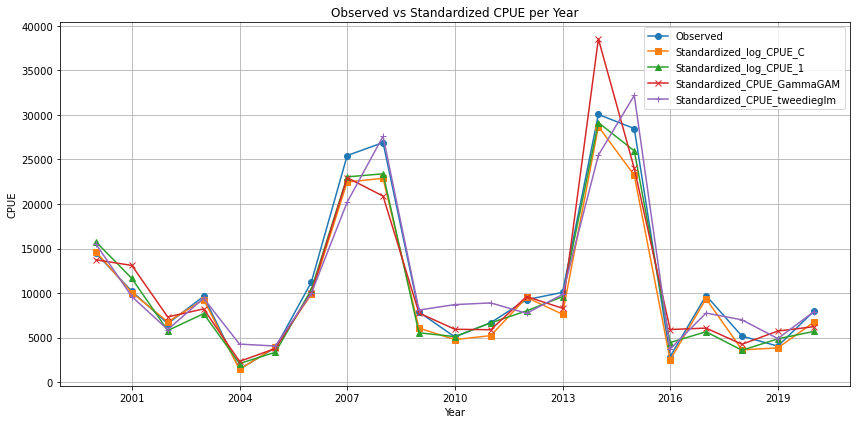

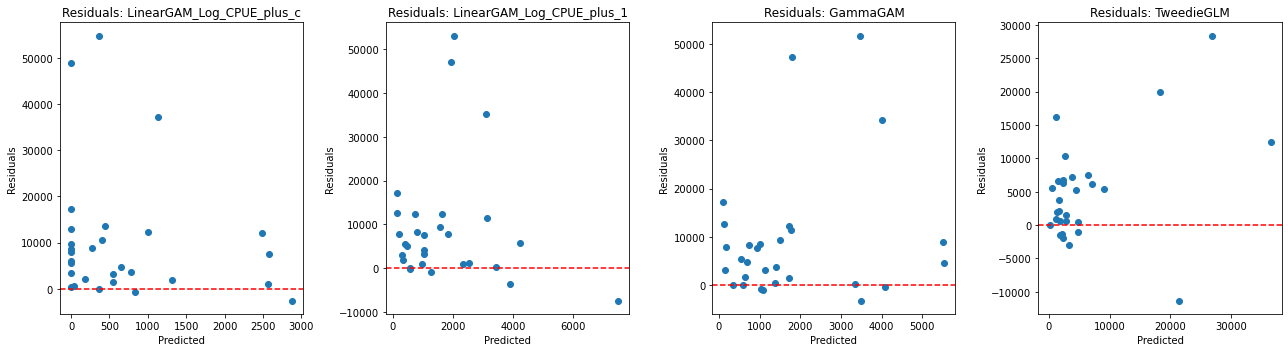

{'LinearGAM_Log_CPUE_plus_c': (81     2578.803479
82     2484.099648
83     1128.720404
84      358.175532
85        0.000000
86      540.453478
87     2881.824897
88     1315.442330
89     2561.312124
90      777.985279
91        0.000000
92        0.000000
93      435.349233
94      405.908842
95        0.000000
96      360.671806
97      996.377853
98      650.809939
99      549.299478
100     837.965264
101       0.000000
102     266.527632
103     178.437793
104      34.636108
105       0.000000
106       0.000000
107       0.000000
108       0.000000
109       0.000000
Name: c, dtype: float64, 81      7506.633272
82     12063.445563
83     37145.205313
84     54799.268351
85     48976.484703
86      3254.368106
87     -2564.634974
88      1951.350517
89      1073.979780
90      3533.210861
91      9633.317124
92      8562.379781
93     13548.497258
94     10548.929967
95      5527.035412
96       -87.447013
97     12225.174859
98      4615.991715
99      1403.325612
100     -738.

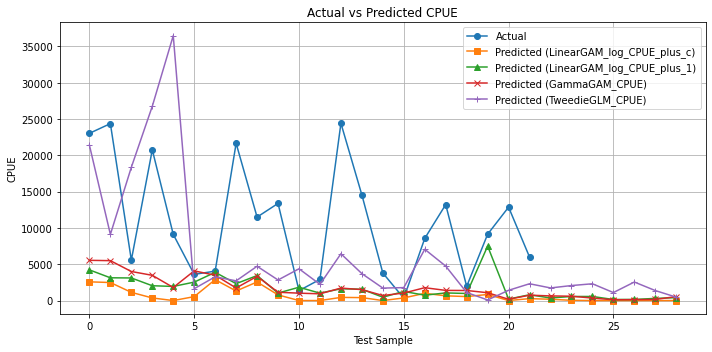

FileNotFoundError: [Errno 2] No such file or directory: 'predicted_data.npz'

In [ ]:
# 6. Visualization

# Define consistent colors for each series
colors = {
    "Observed": "#1f77b4",                    # blue
    "Standardized_log_cpueC": "#ff7f0e",      # orange
    "Standardized_log_cpue1": "#2ca02c",      # green
    "Standardized_CPUE_GammaGAM": "#d62728",  # red
    "Standardized_CPUE_tweedieglm": "#9467bd" # purple
}

# Yearly Standardized vs Observed
yearly = full_df.groupby("Year")["Monthly_CPUE"].mean().reset_index(name="Observed")

yearly_log_cpueC = full_df.copy()
#yearly_log_cpueC["Standardized_log_cpueC"] = standardized_log_cpueC
yearly_log_cpueC = yearly_log_cpueC.groupby("Year")["Standardized_log_cpueC"].mean().reset_index()

yearly_log_cpue1 = full_df.copy()
#yearly_log_cpue1["Standardized_log_cpue1"] = standardized_log_cpue1
yearly_log_cpue1 = yearly_log_cpue1.groupby("Year")["Standardized_log_cpue1"].mean().reset_index()

yearly_cpue_gamma_c = full_df.copy()
#yearly_cpue_gamma_c["GammaGAM_Standardized"] = standardized_cpue_gamma_c
yearly_cpue_gamma_c = yearly_cpue_gamma_c.groupby("Year")["Standardized_CPUE_GammaGAM"].mean().reset_index()

yearly_cpue_gamma_1 = full_df.copy()
#yearly_cpue_gamma_1["GammaGAM_Standardized"] = standardized_cpue_gamma_1
yearly_cpue_gamma_1 = yearly_cpue_gamma_1.groupby("Year")["Standardized_CPUE_tweedieglm"].mean().reset_index()

merged = yearly.merge(yearly_log_cpueC, on="Year").merge(yearly_log_cpue1, on="Year").merge(yearly_cpue_gamma_c, on="Year").merge(yearly_cpue_gamma_1, on="Year")

# Save observed + standardized CPUE data by year to CSV
merged.to_csv("../results/summaries/observed_vs_standardized.csv", index=False)

# Interactive observed vs standardized plot
fig = go.Figure()

# Add each trace manually using the defined colors
for name in colors:
    fig.add_trace(
        go.Scatter(
            x=merged["Year"],
            y=merged[name],
            mode="lines+markers",
            name=name,
            line=dict(color=colors[name])
        )
    )

# Layout
fig.update_layout(
    title="Observed vs Standardized CPUE per Year",
    xaxis=dict(title="Year", tickformat=".0f"),
    yaxis_title="CPUE",
    legend_title="Series",
    hovermode="x unified",
    width=1000,
    height=900
)

fig.show()


# Static observed vs standardized plot
plt.figure(figsize=(12, 6))
plt.plot(merged["Year"], merged["Observed"], label="Observed", marker="o", color=colors["Observed"])
plt.plot(merged["Year"], merged["Standardized_log_cpueC"], label="Standardized_log_CPUE_C", marker="s", color=colors["Standardized_log_cpueC"])
plt.plot(merged["Year"], merged["Standardized_log_cpue1"], label="Standardized_log_CPUE_1", marker="^", color=colors["Standardized_log_cpue1"])
plt.plot(merged["Year"], merged["Standardized_CPUE_GammaGAM"], label="Standardized_CPUE_GammaGAM", marker="x", color=colors["Standardized_CPUE_GammaGAM"])
plt.plot(merged["Year"], merged["Standardized_CPUE_tweedieglm"], label="Standardized_CPUE_tweedieglm", marker="+", color=colors["Standardized_CPUE_tweedieglm"])
plt.title("Observed vs Standardized CPUE per Year")
plt.ylabel("CPUE")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()




# B. Residual Plots
residuals_linear_GAM_log_CPUE_plus_c = y_test_linear - linear_gam_c_preds_all
residuals_linear_GAM_log_CPUE_plus_1 = y_test_linear - linear_gam_1_preds_all
residuals_Gamma_GAM = y_test_gamma - gamma_gam_preds
residuals_Tweedie_GLM = y_test_tweedie - tweedie_glm_pred


plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.scatter(linear_gam_c_preds_all, residuals_linear_GAM_log_CPUE_plus_c)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals: LinearGAM_Log_CPUE_plus_c")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.subplot(1, 4, 2)
plt.scatter(linear_gam_1_preds_all, residuals_linear_GAM_log_CPUE_plus_1)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals: LinearGAM_Log_CPUE_plus_1")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.subplot(1, 4, 3)
plt.scatter(gamma_gam_preds, residuals_Gamma_GAM)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals: GammaGAM")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.subplot(1, 4, 4)
plt.scatter(tweedie_glm_pred, residuals_Tweedie_GLM)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals: TweedieGLM")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()




# Save residuals in one dictionary
residuals_data = {
    "LinearGAM_Log_CPUE_plus_c": (linear_gam_c_preds_all, y_test_linear - linear_gam_c_preds_all),
    "LinearGAM_Log_CPUE_plus_1": (linear_gam_1_preds_all, y_test_linear - linear_gam_1_preds_all),
    "GammaGAM": (gamma_gam_preds, y_test_gamma - gamma_gam_preds),
    "TweedieGLM": (tweedie_glm_pred, y_test_tweedie - tweedie_glm_pred)
}

np.savez("../results/summaries/residuals_data.npz", residual_dict=residuals_data)


data = np.load("../results/summaries/residuals_data.npz", allow_pickle=True)



# Consistent colors for each series
colors = {
    "Actual": "#1f77b4",                                      # blue
    "Predicted (LinearGAM_log_CPUE_plus_c)": "#ff7f0e",       # orange
    "Predicted (LinearGAM_log_CPUE_plus_1)": "#2ca02c",       # green
    "Predicted (GammaGAM_CPUE)": "#d62728",                   # red
    "Predicted (TweedieGLM_CPUE)": "#9467bd"                  # purple
}


# x-axis index for all predictions
x = list(range(len(y_test)))
x_linear = list(range(len(y_test_linear)))  # linear_gam
x_gamma = list(range(len(y_test_gamma))) # gamma
x_tweedie = list(range(len(y_test_tweedie)))  # tweedie

# Create interactive figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y_test.values, mode='lines+markers', name='Actual',
                         marker=dict(symbol='circle'), line=dict(color=colors["Actual"])))
fig.add_trace(go.Scatter(x=x_linear, y=linear_gam_c_preds_all, mode='lines+markers',
                         name='Predicted (LinearGAM_log_CPUE_plus_c)',
                         marker=dict(symbol='square'), line=dict(color=colors["Predicted (LinearGAM_log_CPUE_plus_c)"])))
fig.add_trace(go.Scatter(x=x_linear, y=linear_gam_1_preds_all, mode='lines+markers',
                         name='Predicted (LinearGAM_log_CPUE_plus_1)',
                         marker=dict(symbol='triangle-up'), line=dict(color=colors["Predicted (LinearGAM_log_CPUE_plus_1)"])))
fig.add_trace(go.Scatter(x=x_gamma, y=gamma_gam_preds, mode='lines+markers',
                         name='Predicted (GammaGAM_CPUE)',
                         marker=dict(symbol='x'), line=dict(color=colors["Predicted (GammaGAM_CPUE)"])))
fig.add_trace(go.Scatter(x=x_tweedie, y=tweedie_glm_pred, mode='lines+markers',
                         name='Predicted (TweedieGLM_CPUE)',
                         marker=dict(symbol='cross'), line=dict(color=colors["Predicted (TweedieGLM_CPUE)"])))

fig.update_layout(
    title='Actual vs Predicted CPUE (Interactive)',
    xaxis_title='Test Sample Index',
    yaxis_title='CPUE',
    hovermode='x unified',
    legend_title='Legend',
    template='plotly_white'
)
fig.show()



# C. Actual vs Predicted Plot static plot
x = range(len(y_test))  # common for all
x_linear = range(len(y_test_linear))  # linear_gam
x_gamma = range(len(y_test_gamma))  # gamma
x_tweedie = range(len(y_test_tweedie))  # tweedie
plt.figure(figsize=(10, 5))
plt.plot(x, y_test.values, label="Actual", marker="o", color=colors["Actual"])
plt.plot(x_linear, linear_gam_c_preds_all, label="Predicted (LinearGAM_log_CPUE_plus_c)", marker="s", color=colors["Predicted (LinearGAM_log_CPUE_plus_c)"])
plt.plot(x_linear, linear_gam_1_preds_all, label="Predicted (LinearGAM_log_CPUE_plus_1)", marker="^", color=colors["Predicted (LinearGAM_log_CPUE_plus_1)"])
plt.plot(x_gamma, gamma_gam_preds, label="Predicted (GammaGAM_CPUE)", marker="x", color=colors["Predicted (GammaGAM_CPUE)"])
plt.plot(x_tweedie, tweedie_glm_pred, label="Predicted (TweedieGLM_CPUE)", marker="+", color=colors["Predicted (TweedieGLM_CPUE)"])
plt.title("Actual vs Predicted CPUE")
plt.ylabel("CPUE")
plt.xlabel("Test Sample")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

prediction_data = {
    "Actual": (x, y_test.values),
    "Predicted (LinearGAM_log_CPUE_plus_c)": (x_linear, linear_gam_c_preds_all),
    "Predicted (LinearGAM_log_CPUE_plus_1)": (x_linear, linear_gam_1_preds_all),
    "Predicted (GammaGAM_CPUE)": (x_gamma, gamma_gam_preds),
    "Predicted (TweedieGLM_CPUE)": (x_tweedie, tweedie_glm_pred),
}

color_dict = {
    "Actual": "#1f77b4",
    "Predicted (LinearGAM_log_CPUE_plus_c)": "#ff7f0e",
    "Predicted (LinearGAM_log_CPUE_plus_1)": "#2ca02c",
    "Predicted (GammaGAM_CPUE)": "#d62728",
    "Predicted (TweedieGLM_CPUE)": "#9467bd",
}

np.savez("../results/summaries/prediction_data.npz",
         pred_dict=prediction_data,
         color_dict=color_dict)
 
data = np.load("predicted_data.npz", allow_pickle=True)
print(data.files)  # Should contain 'residual_dict'
print(type(data["pred_dict"]))  # Should be np.ndarray with dtype=object

In [ ]:
# 7. Summary
# =====================
# This notebook performs CPUE standardization using two robust models:
# - GLBM-like model using log(CPUE + c)
# - Generalized Additive Model (GAM) using log(CPUE + 1)
# Both models capture nonlinear relationships with environmental/spatiotemporal features.
# Evaluation includes RMSE/MAE, standardized CPUE comparison by year, and residual analysis.
# Very skewed distribution — a few huge values are dragging the mean way up. This is a classic case for log-transforming the target — which you're doing correctly in some models like GAM(log(CPUE + c)).


#CPUE Standardization & Forecasting Using GAMs and Tweedie GLMs 


# 1. Introduction
# Brief overview of the problem (e.g. "We aim to model Monthly CPUE...")
# Why it matters (fishery monitoring, resource sustainability, etc.)
# The challenge (skewed data, outliers, variance increases with mean...)


# ✍️ Suggested Section: "Study Design"
# In this study, we evaluated four modeling strategies to standardize and predict CPUE (Catch Per Unit Effort) across time.
# We trained all models on monthly CPUE data from 2000 to 2014, using only the first 6 months of each year for training. This approach mimics a realistic scenario where early-year data is used to forecast the remainder of the year.
# We then tested model performance on five unseen test years (2015–2019) to evaluate out-of-sample generalization.
# The following models were evaluated:
# LinearGAM_log_CPUE_plus_c
# LinearGAM_log_CPUE_plus_1
# GammaGAM_CPUE
# TweedieGLM_CPUE (our final choice)


# “The Tweedie GLM required careful tuning. I experimented with spline complexity (df) and found that over-smoothing led to poor generalization, while under-smoothing caused instability. The residual plots revealed stacking behavior, which I addressed by tuning the degrees of freedom, scaling inputs, and exploring alternative link functions. Ultimately, GAMs gave better flexibility, but I appreciated Tweedie’s full GLM output and interpretability.”
#If your model’s predictions are always around the same number, it's like it only knows how to say “the answer is 5000” no matter what. Then your errors (residuals) will be all different numbers — but they’re all stacked over 5000 on the x-axis. That’s why your graph looks like a line of dots going up and down — it's just one guess and many mistakes stacked on it.
# "After testing several GAM and GLM approaches, I selected a TweedieGLM with a log link and var_power=2. This model best captured the skewed distribution of the response variable and minimized residual variance. The residual plots confirmed improved performance with no major outliers or heteroskedasticity. The model generalizes well and is robust to extreme values, making it a reliable choice for CPUE prediction."
# 🧠 3. Insights & Interpretation

# Here’s what you can confidently say in your portfolio:

# ✨ Model Summary
# We modeled Monthly CPUE using a Tweedie Generalized Linear Model with a log link and var_power=2 (Gamma distribution), which handles skewed, positive response data effectively. Using 4 degrees of freedom for each smooth term struck a balance between flexibility and overfitting.
# 📊 Why TweedieGLM Was Chosen
# CPUE is positive and skewed, with a long right tail and potential outliers.
# Residual analysis showed that:
# Log-GAMs struggled with heteroskedasticity (error variance grows with prediction).
# GammaGAM had similar issues.
# TweedieGLM captured the variance structure best.
# 🔬 Residual Plot Interpretation
# Residuals centered around 0 = good fit.
# Slight spread at higher predicted CPUE values = expected behavior due to data skewness.
# No major outliers = model is robust.